# Muon-Decay-Acquire

The following cell acquires and plots a single-pulse or a double-pulse signal depending on the mode selected.

The double pulse is generated on pin DIO_P_7 of Extension Connector E1.

## CAUTION: The pulse amplitude is 3.3 V. Change the range jumper of ADC1 to HV.

### Connect ADC1 to pin DIO_P_7 of of Extension Connector E1. See the next picture.


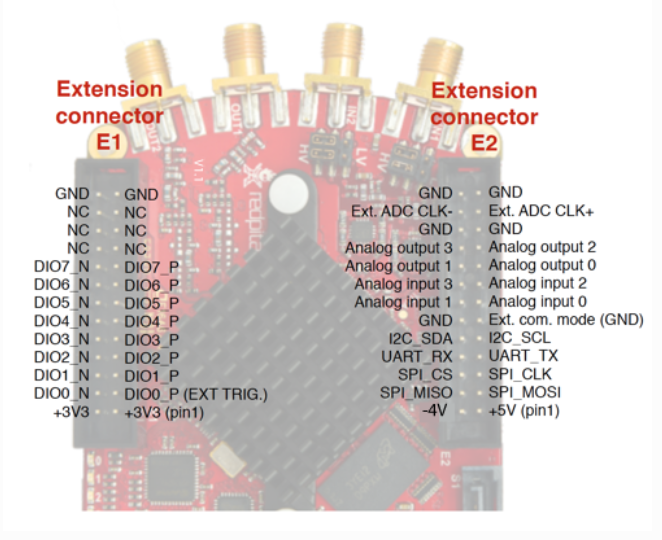

In [8]:
from IPython.display import Image
Image("Extension-Connectors.png")

Program the FPGA with the command *cat Muon-Decay.bit > /dev/xdevcfg*

We use the *periphery module*. 

We arm the trigger (MODE 0 is for single pulse and MODE 1 for double pulse) and generate two pulses of identical WIDTHS and separated by DELTA_TIME.

TRESHOLD_COUNTS =  8151 for TRESHOLD_VOLT = 0.1  Volt
NUM SINGE-PULSES =  57234  NUM DOUBLE-PULSES =  237
Measured Delta Time Between the Two Pulses =   1008  ns
Pointer at trigger=  3120  = 0xc30


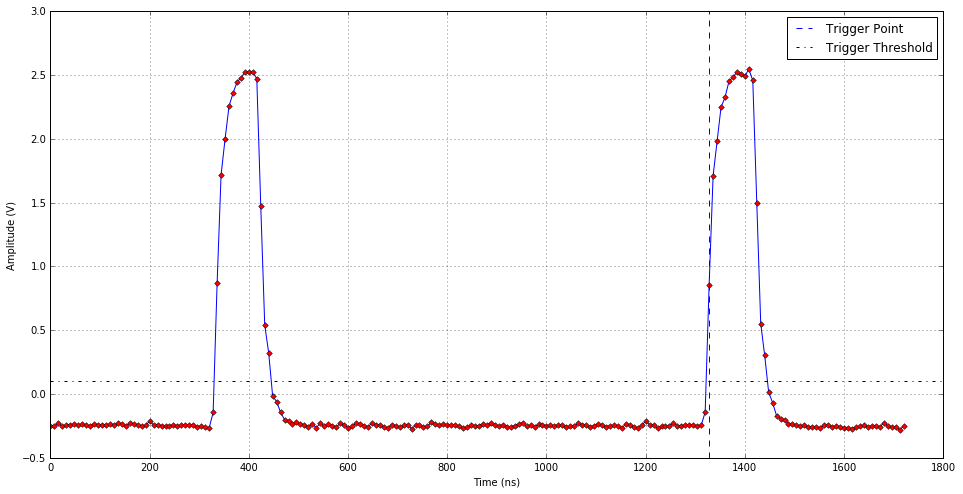

In [10]:
#!/usr/bin/python

##########################################################################inputs
CHANNEL = 1 # 1 
#GAIN = 1 # +- 1 V
GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = .1 # Volt
POINTS_SAVE_AFTER_TRIGGER = 400 # ns
WINDOW_DOUBLE_PULSE = 20000 # ns
EDGE = 1 # 1 for PosEdge trigger  0 for NegEdge trigger
MODE = 1 # # MODE = 0 Single-Pulse Trigger   MODE = 1  Double-Pulse Trigger
VETO = 200 # ns
################ Pulse Generator #################
WIDTH = 100 # ns
DELTA_TIME = 1000 # ns
PULSE_TYPE = 0 # 0 for pos 1 for neg
##########################################################################
WINDOW_DOUBLE_PULSE = int(WINDOW_DOUBLE_PULSE/8)
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
VETO = int (VETO/8)
#POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE
if (MODE == 0):
    DELAY = 3   # 3 is the constant delay of trigger in Single-pulse mode
else:
    DELAY = 5  # 5 is the constant delay if trigger in Double-pulse mode
TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")

from periphery import MMIO
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256+WINDOW_DOUBLE_PULSE) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.write32(8,MODE) # MODE = 0 SINGLE  MODE = 1 DOUBLE
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256) - DELAY
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,VETO*16 + EDGE) # TRIGGER EDGE and VETO
regset.close()

###################DOUBLE PULSE GENERATOR ##########################
WIDTH = int (WIDTH/8) 
DELTA_TIME = int (DELTA_TIME/8)
regset = MMIO(0x41210000, 0xc)
regset.write32(0,DELTA_TIME*256*256+WIDTH*16 + 2*PULSE_TYPE) 
regset.write32(0,DELTA_TIME*256*256+WIDTH*16 + 2*PULSE_TYPE + 1) 
NUM_SINGLES = regset.read32(8) % (256*256)
NUM_DOUBLES = int(regset.read32(8) / (256*256))
print ("NUM SINGE-PULSES = ", NUM_SINGLES, " NUM DOUBLE-PULSES = ",NUM_DOUBLES)
regset.close()

####################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256) - DELAY
    if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
        break  
regset.close()
####################################################################
if MODE == 1:
    regset = MMIO(0x41230000, 0xc)
    DT_BETWEEN_PULSES = regset.read32(0)
    print("Measured Delta Time Between first and last trigger =  ",DT_BETWEEN_PULSES*8, " ns")
    regset.close()
else:
    DT_BETWEEN_PULSES = POINTS_SAVE_AFTER_TRIGGER - 40
####################################################################
regset = MMIO(0x41200000, 0xc)

print("Pointer at trigger= ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-DT_BETWEEN_PULSES-40,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = (DT_BETWEEN_PULSES+40)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()

We can replot the last plot using Plotly.  

### To install Plotly execute *sudo pip3 install plotly*

In [37]:
import plotly
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y,mode='lines+markers',
    line=dict(color="green",  width=2),
    marker=dict(color="blue", size=4)))
fig.update_layout(
    title="Double-Pulse Event Produced with the Generator",
    xaxis_title="Time (ns)",
    yaxis_title="Amplitude (V)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"))
fig.add_vline(x=(DT_BETWEEN_PULSES+40)*8, line_width=1, line_dash="dash", line_color="green")
fig.add_hline(y=TRESHOLD_VOLT, line_width=1, line_dash="dash", line_color="blue")

fig.show()

Another double-pulse example with different parameters

TRESHOLD_COUNTS =  7987 for TRESHOLD_VOLT = 0.5  Volt
NUM SINGE-PULSES =  57246  NUM DOUBLE-PULSES =  242
Measured Delta Time Between the Two Pulses =   816  ns
Pointer at trigger=  3683  = 0xe63


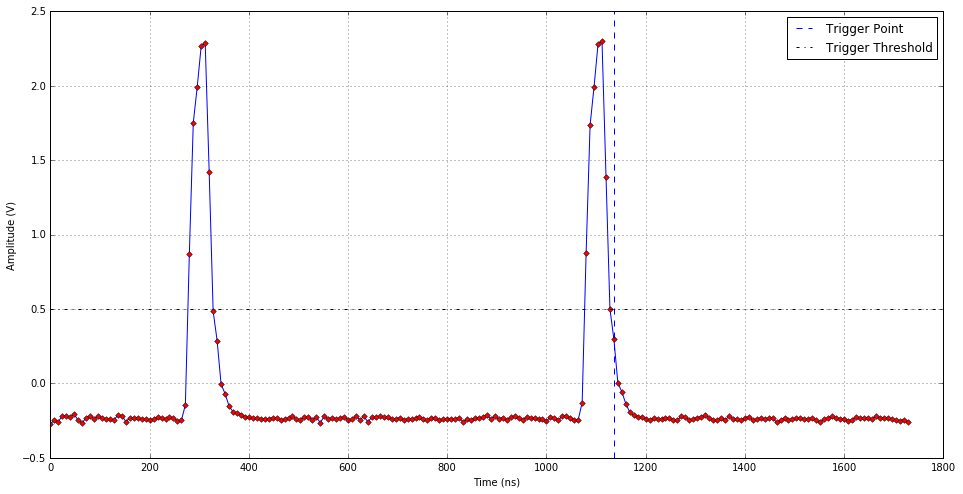

In [15]:
#!/usr/bin/python

##########################################################################inputs
CHANNEL = 1 # 1 
#GAIN = 1 # +- 1 V
GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = .5 # Volt
POINTS_SAVE_AFTER_TRIGGER = 600 # ns
WINDOW_DOUBLE_PULSE = 20000 # ns
EDGE = 0 # 1 for PosEdge trigger  0 for NegEdge trigger
MODE = 1 # # MODE = 0 Single-Pulse Trigger   MODE = 1  Double-Pulse Trigger
VETO = 200 # ns
################ Pulse Generator #################
WIDTH = 40 # ns
DELTA_TIME = 800 # ns
PULSE_TYPE = 0 # 0 for pos 1 for neg
##########################################################################
WINDOW_DOUBLE_PULSE = int(WINDOW_DOUBLE_PULSE/8)
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
VETO = int (VETO/8)
#POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE
if (MODE == 0):
    DELAY = 3   # 3 is the constant delay of trigger in Single-pulse mode
else:
    DELAY = 5  # 5 is the constant delay if trigger in Double-pulse mode
TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")

from periphery import MMIO
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256+WINDOW_DOUBLE_PULSE) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.write32(8,MODE) # MODE = 0 SINGLE  MODE = 1 DOUBLE
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256) - DELAY
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,VETO*16 + EDGE) # TRIGGER EDGE and VETO
regset.close()

###################DOUBLE PULSE GENERATOR ##########################
WIDTH = int (WIDTH/8) 
DELTA_TIME = int (DELTA_TIME/8)
regset = MMIO(0x41210000, 0xc)
regset.write32(0,DELTA_TIME*256*256+WIDTH*16 + 2*PULSE_TYPE) 
regset.write32(0,DELTA_TIME*256*256+WIDTH*16 + 2*PULSE_TYPE + 1) 
NUM_SINGLES = regset.read32(8) % (256*256)
NUM_DOUBLES = int(regset.read32(8) / (256*256))
print ("NUM SINGE-PULSES = ", NUM_SINGLES, " NUM DOUBLE-PULSES = ",NUM_DOUBLES)
regset.close()

####################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256) - DELAY
    if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
        break  
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
DT_BETWEEN_PULSES = regset.read32(0)
print("Measured Delta Time Between first and last trigger =  ",DT_BETWEEN_PULSES*8, " ns")
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)

print("Pointer at trigger= ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-DT_BETWEEN_PULSES-40,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = (DT_BETWEEN_PULSES+40)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()

The next cell uploads an arbitrary signal of 1024 points to RAM to be generated on DAC1 at a rate of 125 MHz.

The arbitrary signal has an  amplitude between -1 V and +1 V and a time extension of  1024*8 ns = 8192 ns.

### Connect ADC1 to DAC1.

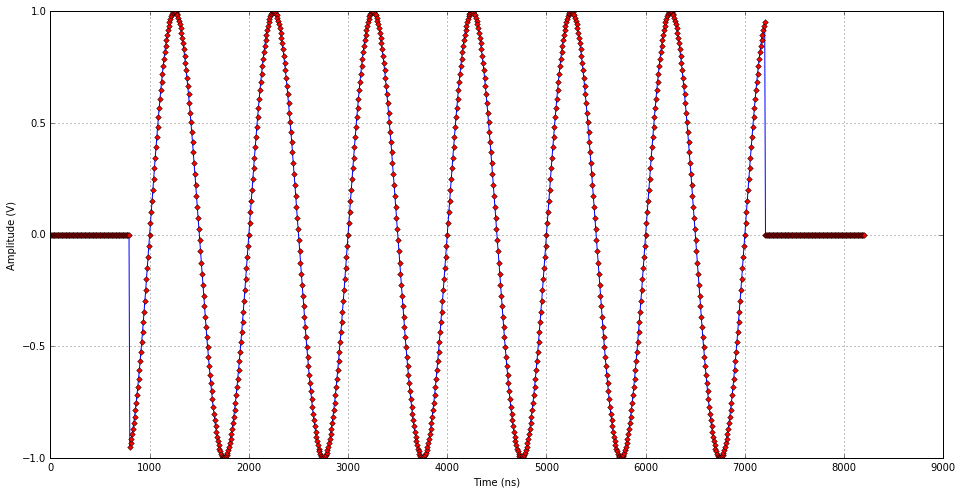

In [34]:
#!/usr/bin/python
###############################################################
PERIOD = 1000 # ns
###############################################################
PERIOD = int(PERIOD/8)
import numpy as np
from periphery import MMIO
from time import *

dat = []
####################################################################
regset = MMIO(0x41240000, 0xc)
regset.write32(0,0)   # Reset port A
regset.write32(0,1)   # Reset port A

for i in range(1024+2):
    y = np.sin(2*np.pi*i/PERIOD)
    if (i <100 or i > 900):
        y=0
    COUNTS = int(y * 2**14/(-2) + 2**13)

    regset.write32(0,COUNTS*256*256+2)
    regset.write32(0,COUNTS*256*256+1+2)
    dat.append(y)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
plt.show()
####################################################################


Here we arm the trigger in Mode 0 (MODE 0 is for single pulse and MODE 1 for double pulse) and generate one single instance of the arbitrary signal uploaded above

TRESHOLD_COUNTS =  8151 for TRESHOLD_VOLT = 0.1  Volt
NUM SINGE-PULSES =  12391  NUM DOUBLE-PULSES =  332
Pointer at trigger=  334  = 0x14e


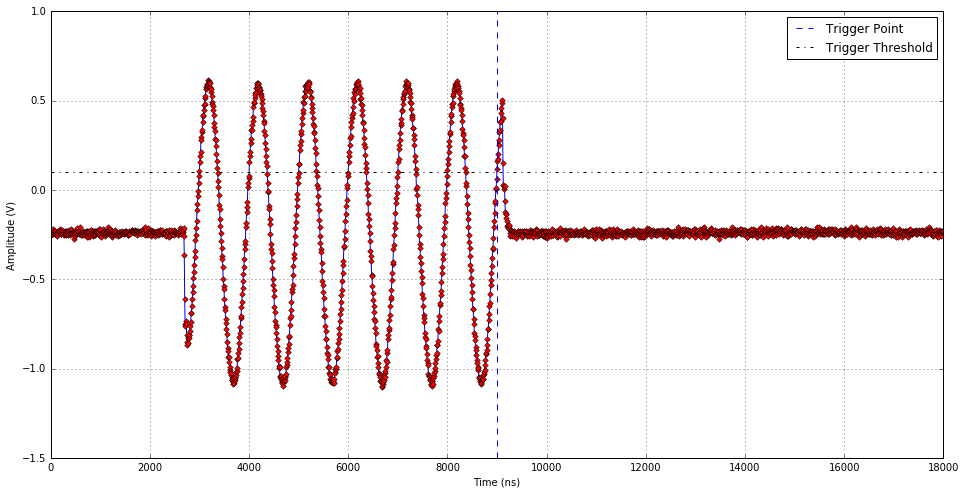

In [21]:
#!/usr/bin/python

##########################################################################inputs
CHANNEL = 1 # 1 
#GAIN = 1 # +- 1 V
GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = .1 # Volt
POINTS_SAVE_AFTER_TRIGGER = 9000 # ns
WINDOW_DOUBLE_PULSE = 20000 # ns
EDGE = 1 # 1 for PosEdge trigger  0 for NegEdge trigger
MODE = 0 # # MODE = 0 Single-Pulse Trigger   MODE = 1  Double-Pulse Trigger
VETO = 200 # ns
################ Pulse Generator #################
WIDTH = 100 # ns
DELTA_TIME = 1500 # ns
PULSE_TYPE = 0 # 0 for pos 1 for neg
##########################################################################
WINDOW_DOUBLE_PULSE = int(WINDOW_DOUBLE_PULSE/8)
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
VETO = int (VETO/8)
#POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE
if (MODE == 0):
    DELAY = 3   # 3 is the constant delay of trigger in Single-pulse mode
else:
    DELAY = 5  # 5 is the constant delay if trigger in Double-pulse mode
TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")

from periphery import MMIO
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256+WINDOW_DOUBLE_PULSE) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.write32(8,MODE) # MODE = 0 SINGLE  MODE = 1 DOUBLE
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256) - DELAY
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,VETO*16 + EDGE) # TRIGGER EDGE and VETO
regset.close()

##################################   ASG   ##################################
regset = MMIO(0x41240000, 0xc)
regset.write32(0,0)   # Reset port B
regset.write32(0,4)   # Reset port B
regset.close()
#############################################################################

regset = MMIO(0x41210000, 0xc)
NUM_SINGLES = regset.read32(8) % (256*256)
NUM_DOUBLES = int(regset.read32(8) / (256*256))
print ("NUM SINGE-PULSES = ", NUM_SINGLES, " NUM DOUBLE-PULSES = ",NUM_DOUBLES)
regset.close()

####################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256) - DELAY
    if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
        break  
regset.close()
####################################################################
if MODE == 1:
    regset = MMIO(0x41230000, 0xc)
    DT_BETWEEN_PULSES = regset.read32(0)
    print("Measured Delta Time Between first and last trigger =  ",DT_BETWEEN_PULSES*8, " ns")
    regset.close()
else:
    DT_BETWEEN_PULSES = POINTS_SAVE_AFTER_TRIGGER - 40
####################################################################
regset = MMIO(0x41200000, 0xc)

print("Pointer at trigger= ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-DT_BETWEEN_PULSES-40,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = (DT_BETWEEN_PULSES+40)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()

Now we arm the trigger in MODE 1 (MODE 0 is for single pulse and MODE 1 for double pulse) and generate one single instance of the arbitrary signal uploaded above

TRESHOLD_COUNTS =  8110 for TRESHOLD_VOLT = 0.2  Volt
NUM SINGE-PULSES =  12466  NUM DOUBLE-PULSES =  342
Measured Delta Time Between first and last trigger =   6016  ns
Pointer at trigger=  2288  = 0x8f0


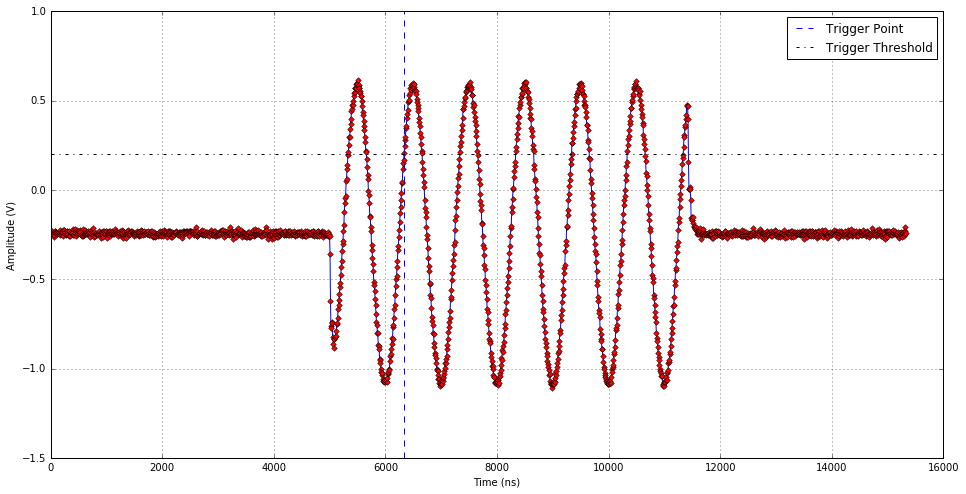

In [36]:
#!/usr/bin/python

##########################################################################inputs
CHANNEL = 1 # 1 
#GAIN = 1 # +- 1 V
GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = .2 # Volt
POINTS_SAVE_AFTER_TRIGGER = 9000 # ns
WINDOW_DOUBLE_PULSE = 20000 # ns
EDGE = 1 # 1 for PosEdge trigger  0 for NegEdge trigger
MODE = 1 # # MODE = 0 Single-Pulse Trigger   MODE = 1  Double-Pulse Trigger
VETO = 200 # ns
################ Pulse Generator #################
WIDTH = 100 # ns
DELTA_TIME = 1500 # ns
PULSE_TYPE = 0 # 0 for pos 1 for neg
##########################################################################
WINDOW_DOUBLE_PULSE = int(WINDOW_DOUBLE_PULSE/8)
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
VETO = int (VETO/8)
#POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE
if (MODE == 0):
    DELAY = 3   # 3 is the constant delay of trigger in Single-pulse mode
else:
    DELAY = 5  # 5 is the constant delay if trigger in Double-pulse mode
TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")

from periphery import MMIO
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256+WINDOW_DOUBLE_PULSE) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.write32(8,MODE) # MODE = 0 SINGLE  MODE = 1 DOUBLE
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256) - DELAY
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,VETO*16 + EDGE) # TRIGGER EDGE and VETO
regset.close()

##################################   ASG   ##################################
regset = MMIO(0x41240000, 0xc)
regset.write32(0,0)   # Reset port B
regset.write32(0,4)   # Reset port B
regset.close()
#############################################################################

regset = MMIO(0x41210000, 0xc)
NUM_SINGLES = regset.read32(8) % (256*256)
NUM_DOUBLES = int(regset.read32(8) / (256*256))
print ("NUM SINGE-PULSES = ", NUM_SINGLES, " NUM DOUBLE-PULSES = ",NUM_DOUBLES)
regset.close()

####################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256) - DELAY
    if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
        break  
regset.close()
####################################################################
if MODE == 1:
    regset = MMIO(0x41230000, 0xc)
    DT_BETWEEN_PULSES = regset.read32(0)
    print("Measured Delta Time Between first and last trigger =  ",DT_BETWEEN_PULSES*8, " ns")
    regset.close()
else:
    DT_BETWEEN_PULSES = POINTS_SAVE_AFTER_TRIGGER - 40
####################################################################
regset = MMIO(0x41200000, 0xc)

print("Pointer at trigger= ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-DT_BETWEEN_PULSES-40,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = (DT_BETWEEN_PULSES+40)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()

We can veto 1200 ns after the first trigger so that the double-pulse trigger is shifted one period as ilustrated below

TRESHOLD_COUNTS =  8110 for TRESHOLD_VOLT = 0.2  Volt
NUM SINGE-PULSES =  12473  NUM DOUBLE-PULSES =  343
Measured Delta Time Between first and last trigger =   6008  ns
Pointer at trigger=  601  = 0x259


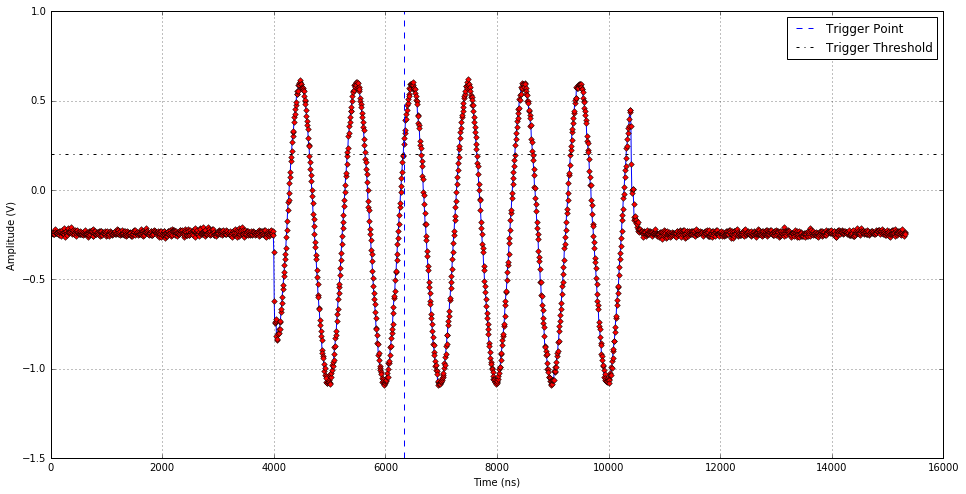

In [38]:
#!/usr/bin/python

##########################################################################inputs
CHANNEL = 1 # 1 
#GAIN = 1 # +- 1 V
GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = .2 # Volt
POINTS_SAVE_AFTER_TRIGGER = 9000 # ns
WINDOW_DOUBLE_PULSE = 20000 # ns
EDGE = 1 # 1 for PosEdge trigger  0 for NegEdge trigger
MODE = 1 # # MODE = 0 Single-Pulse Trigger   MODE = 1  Double-Pulse Trigger
VETO = 1200 # ns
################ Pulse Generator #################
WIDTH = 100 # ns
DELTA_TIME = 1500 # ns
PULSE_TYPE = 0 # 0 for pos 1 for neg
##########################################################################
WINDOW_DOUBLE_PULSE = int(WINDOW_DOUBLE_PULSE/8)
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
VETO = int (VETO/8)
#POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE
if (MODE == 0):
    DELAY = 3   # 3 is the constant delay of trigger in Single-pulse mode
else:
    DELAY = 5  # 5 is the constant delay if trigger in Double-pulse mode
TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")

from periphery import MMIO
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256+WINDOW_DOUBLE_PULSE) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.write32(8,MODE) # MODE = 0 SINGLE  MODE = 1 DOUBLE
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256) - DELAY
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,VETO*16 + EDGE) # TRIGGER EDGE and VETO
regset.close()

##################################   ASG   ##################################
regset = MMIO(0x41240000, 0xc)
regset.write32(0,0)   # Reset port B
regset.write32(0,4)   # Reset port B
regset.close()
#############################################################################

regset = MMIO(0x41210000, 0xc)
NUM_SINGLES = regset.read32(8) % (256*256)
NUM_DOUBLES = int(regset.read32(8) / (256*256))
print ("NUM SINGE-PULSES = ", NUM_SINGLES, " NUM DOUBLE-PULSES = ",NUM_DOUBLES)
regset.close()

####################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256) - DELAY
    if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
        break  
regset.close()
####################################################################
if MODE == 1:
    regset = MMIO(0x41230000, 0xc)
    DT_BETWEEN_PULSES = regset.read32(0)
    print("Measured Delta Time Between first and last trigger =  ",DT_BETWEEN_PULSES*8, " ns")
    regset.close()
else:
    DT_BETWEEN_PULSES = POINTS_SAVE_AFTER_TRIGGER - 40
####################################################################
regset = MMIO(0x41200000, 0xc)

print("Pointer at trigger= ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-DT_BETWEEN_PULSES-40,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = (DT_BETWEEN_PULSES+40)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()